In [1]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [58]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("diet_data.csv")

Saving diet_data.csv to diet_data (4).csv


In [59]:
df.head()
print("Shape:", df.shape)

Shape: (3000, 18)


In [60]:
print("Disease", df['Disease'].unique())
print("Severity", df['Severity'].unique())
print("Stamina", df['Stamina'].unique())

Disease ['Stress' 'Hypertension' nan 'Diabetes' 'Anxiety' 'Thyroid' 'Obesity'
 'LowIron']
Severity ['Moderate' nan 'Mild' 'Severe']
Stamina ['High' 'Medium' 'Low']


In [61]:
print("DietRecommendation", df['DietRecommendation'].unique())

DietRecommendation ['Mediterranean diet' 'Low-salt DASH diet' 'Balanced Indian diet'
 'Low-carb diabetic diet' 'Anti-inflammatory diet' 'High-protein diet'
 'Calorie deficit diet']


In [62]:
# Drop unwanted columns
cols_to_drop = ['BMI', 'Height_cm', 'State','Region','NutrientImbalance','Exercise_hr_week','Age','Gender','Metabolism']
df = df.drop(columns=cols_to_drop)

# Convert BP "120/80" → numeric mean
def convert_bp(bp):
    if isinstance(bp, str) and "/" in bp:
        top, bottom = bp.split("/")
        return (float(top) + float(bottom)) / 2
    return np.nan

df["BP"] = df["BP"].apply(convert_bp)

# Remove rows where BP couldn't convert
df = df.dropna(subset=["BP"])
df.reset_index(drop=True, inplace=True)


In [63]:
df.head()

,Weight_kg,BP,Glucose,HeartRate,Stamina,Disease,Severity,DailyCalories,DietRecommendation
0,54.9,96.5,102,105,High,Stress,Moderate,1940,Mediterranean diet
1,67.7,119.0,143,88,Medium,Hypertension,Moderate,2130,Low-salt DASH diet
2,79.7,100.0,79,66,Medium,NaN,NaN,2290,Balanced Indian diet
3,66.0,105.5,100,78,Medium,Hypertension,Mild,1911,Low-salt DASH diet
4,57.2,96.5,74,67,High,NaN,NaN,2225,Balanced Indian diet


In [64]:
target_col = "DietRecommendation"

In [65]:
# ENCODING
X = df.drop(columns=[target_col]).copy()

y_raw = df[target_col].copy()

In [66]:
X.head()

,Weight_kg,BP,Glucose,HeartRate,Stamina,Disease,Severity,DailyCalories
0,54.9,96.5,102,105,High,Stress,Moderate,1940
1,67.7,119.0,143,88,Medium,Hypertension,Moderate,2130
2,79.7,100.0,79,66,Medium,NaN,NaN,2290
3,66.0,105.5,100,78,Medium,Hypertension,Mild,1911
4,57.2,96.5,74,67,High,NaN,NaN,2225


In [67]:
#Encode non-numeric features
non_numeric_cols = X.columns[X.dtypes == "object"].tolist()
non_numeric_cols += X.columns[X.dtypes == "category"].tolist()
non_numeric_cols = list(dict.fromkeys(non_numeric_cols))

label_encoders = {}
for col in non_numeric_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode target
target_le = LabelEncoder()
y = target_le.fit_transform(y_raw.astype(str))

# SCALE FEATURES
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [68]:
# --------------------------------------------------------
# TRAIN–TEST SPLIT
# --------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

In [69]:
print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTrain class counts (before balancing):")
print(pd.Series(y_train).value_counts().sort_index())

print("\nTest class counts (UNBALANCED — correct behaviour):")
print(pd.Series(y_test).value_counts().sort_index())


Train shape: (2400, 8)
Test shape: (600, 8)

Train class counts (before balancing):
0      84
1    1628
2     197
3      43
4     157
5     185
6     106
Name: count, dtype: int64

Test class counts (UNBALANCED — correct behaviour):
0     21
1    407
2     50
3     11
4     39
5     46
6     26
Name: count, dtype: int64


In [70]:
X_train_bal, y_train_bal = X_train, y_train

# --------------------------------------------------------
# MODEL TRAINING & TEST EVALUATION
# --------------------------------------------------------
def evaluate_model(model, X_tr, y_tr, X_te, y_te, name="Model"):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    print(f"\n=== {name} - Test Classification Report ===")
    print(classification_report(y_te, y_pred, digits=4, target_names=target_le.classes_))

    cm = confusion_matrix(y_te, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_le.classes_)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"{name} - Confusion Matrix (Test)")
    plt.show()

    return model, y_pred


=== Random Forest - Test Classification Report ===
                        precision    recall  f1-score   support

Anti-inflammatory diet     1.0000    1.0000    1.0000        21
  Balanced Indian diet     1.0000    1.0000    1.0000       407
  Calorie deficit diet     0.9804    1.0000    0.9901        50
     High-protein diet     1.0000    0.9091    0.9524        11
Low-carb diabetic diet     0.9512    1.0000    0.9750        39
    Low-salt DASH diet     1.0000    0.9565    0.9778        46
    Mediterranean diet     0.9615    0.9615    0.9615        26

              accuracy                         0.9933       600
             macro avg     0.9847    0.9753    0.9795       600
          weighted avg     0.9935    0.9933    0.9933       600



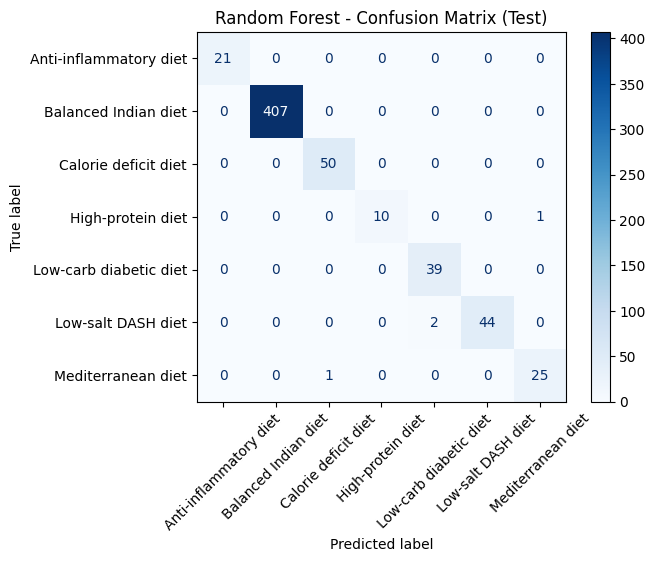

In [71]:
# --------------------------------------------------------
# RANDOM FOREST
# --------------------------------------------------------
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

rf, rf_y_pred = evaluate_model(
    rf, X_train_bal, y_train_bal, X_test, y_test, name="Random Forest"
)


Top 10 feature importances (Random Forest):
Disease          0.397027
BP               0.150545
Severity         0.139083
HeartRate        0.118500
Glucose          0.088553
Weight_kg        0.053916
DailyCalories    0.040326
Stamina          0.012050
dtype: float64


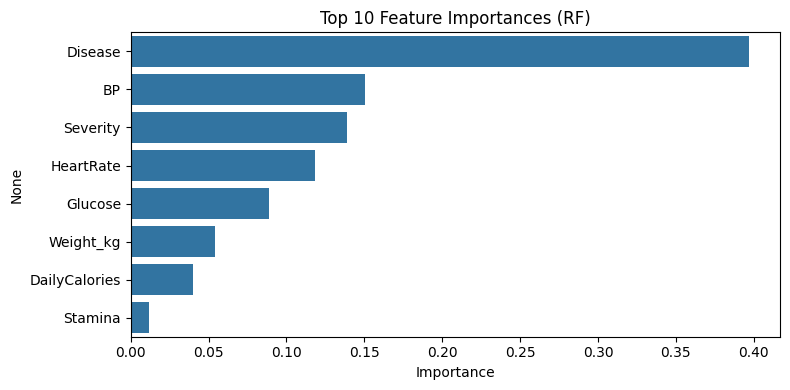

In [72]:
# --------------------------------------------------------
# FEATURE IMPORTANCES
# --------------------------------------------------------
feat_names = X.columns.tolist()
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

print("\nTop 10 feature importances (Random Forest):")
print(feat_imp.head(10))

plt.figure(figsize=(8,4))
sns.barplot(x=feat_imp.head(10).values, y=feat_imp.head(10).index)
plt.title("Top 10 Feature Importances (RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [74]:
#SAVE MODEL + SCALER + LABEL ENCODERS
import pickle
model_data = {
    "model": rf,
    "scaler": scaler,
    "label_encoders": label_encoders,
    "target_encoder": target_le,
    "feature_names": X.columns.tolist()
}

filename = "diet_model.pkl"
with open(filename, "wb") as f:
    pickle.dump(model_data, f)

files.download(filename)

print("\nModel saved as diet_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Model saved as diet_model.pkl
